### Analysis of books appearing on New York Times Weekly Bestseller List [2010 - 2017]

This project explores the books that appeared on the New York Times Bestseller List from 2010 to 2017 and aims to answer the following questions:

1) Which books appeared most often ? 

2) Which authors made the most appearances?

3) Which authors have the most number of books on the list?

4) Is there a relationship between the number of books an author has on the list to his/her number of appearances and average rank?

5) What are some of the common themes seen in books on the list?

Information about weekly bestseller lists was obtained using the NYT API. Information on each book was extracted, including title, author, book description and rank on that week's list.

Pandas and numpy was used to analyze the data and matplotlib/seaborn to visualize trends explore relationships.

nltk, wordcloud were used to visualize the commonly occuring themes for books appearing in list.


In [18]:
# Generates list of dates from 2010 - 2017 to get weekly bestseller lists from NYT API

from datetime import datetime
from datetime import timedelta

def set_date_range(start_date,end_date):
    
    date = start_date
   
    date_list = []
    while date <= end_date:    
        date_list.append(datetime.date(date).isoformat())
        date = date + timedelta(days=7)
        
    return date_list
    #print len(date_list)

start_date = datetime(2010,1,3)
end_date = datetime(2017,12,31)

date_list = set_date_range(start_date, end_date)
#418 calls
#date_list[-1]

'2017-12-31'

In [ ]:
# Get data from NYT API
import requests
import unicodecsv as csv
from pprint import pprint
import sys
import time

# extracts data from json and writes to csv
def get_data_json(date, listname, filename):

    # get personal api key from NYT
    apikey = "XXX"
    url = "http://api.nytimes.com/svc/books/v2/lists/{}/{}.json?api-key={}".format(date,listname,apikey)

    resp = requests.get(url)
    
    if resp:
        contents = resp.json()
    
        booklist = contents['results']

        bookdetails = []
        for book in booklist:
            dct = {}
            dct['author'] = book['book_details'][0]['author']
            dct['amazon_url'] = book['book_details'][0]['amazon_product_url']
            dct['title'] = book['book_details'][0]['title']
            dct['isbn10'] = book['book_details'][0]['primary_isbn10']
            dct['isbn13'] = book['book_details'][0]['primary_isbn13']
            dct['rank'] = book['rank']
            dct['description'] = book['book_details'][0]['description']
            dct['weeks_on_list'] = book['weeks_on_list']
            dct['listname'] = book['list_name_encoded']
            dct['listpublisheddate'] = book['published_date']
            bookdetails.append(dct)

        f=open(filename,'a')
        csv_dict_writer = csv.DictWriter(f,fieldnames = header)
        csv_dict_writer.writerows(bookdetails)
        f.close()   

# specify types of bestseller lists to get info on
listnames= ["trade-fiction-paperback", "paperback-nonfiction"]


header = ['isbn10','isbn13','title','author','rank','weeks_on_list','amazon_url', 
              'listname','description', 'listpublisheddate']

def create_csv(filename,header):
    
    f = open(filename,'w')
    csv_dict_writer = csv.DictWriter(f,fieldnames = header)
    csv_dict_writer.writeheader()
    f.close()

# get data for specified listname and date
for listname in listnames:
    filename = "booklist_{}.csv".format(listname)
    create_csv(filename, header)
    for date in date_list:
        try:
            get_data_json(date,listname,filename)
        except:
            continue
        time.sleep(2)


In [22]:
# Exploratory data analysis on collected data. Used only 1 type of bestseller list for this project

import pandas as pd
import numpy as np

df = pd.read_csv("booklist_trade-fiction-paperback.csv")

print ("No. of records = %d" %(len(df)))

df['author'] = df['author'].apply(lambda x:x.lower())
df['title'] = df['title'].apply(lambda x:x.lower())
df['author-title'] = df['author'] + " - " + df['title']

# top20 lists became top10 lists after a certain date. for comparison, include only top10 entries
fiction = df[df['rank']<=10]

# 19 entries have missing descriptions
fiction['description'].isnull().sum()

print ("No. of unique book titles= %d" %(len(fiction['title'].unique())))
print ("No. of authors = %d" %(len(fiction['author'].unique())))
print ("No. of unique book descriptions = %d" %(len(fiction['description'].unique())))
print ("No. of unique book isbns = %d" %(len(fiction['isbn13'].unique())))


No. of records = 6980
No. of unique book titles= 358
No. of authors = 210
No. of unique book descriptions = 445
No. of unique book isbns = 385


Number of unique titles, isbns and descriptions should match. 

As they don't, this suggests the following:

-different book editions (isbn13) of the same book were were given on different weekly lists 

-different descriptions of the same book were given on different weekly lists 

Use unique book titles as a basis to clean the book descriptions. 
If there's more than 1 description for the same book, use the longest description for all records


In [23]:
### clean the book descriptions

def clean_desc(df): 
    
    descs = df['description'].unique()
    unified_desc = descs.max()
    df['description'] = unified_desc 
   
    return df

fiction_cleaned = fiction.groupby('title').apply(lambda x: clean_desc(x))

# There are a few books with missing descriptions
print len(fiction_cleaned['description'].unique())


354


In [25]:
# get info on number of weeks that author/book appeared on list, as well as average rank of each author and book

num_authappear = fiction_cleaned['author'].value_counts().sort_values(ascending=True)
num_bookappear = fiction_cleaned['author-title'].value_counts().sort_values(ascending=True)
avg_bookrank = fiction_cleaned.groupby('title')['rank'].mean()
avg_authrank = fiction_cleaned.groupby('author')['rank'].mean()


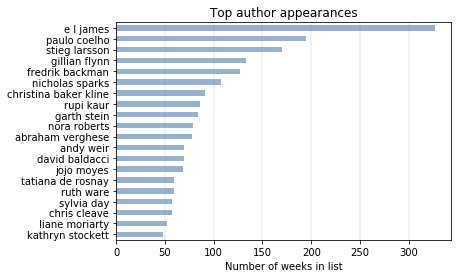

In [29]:
# visualize the authors appearing most often 

import matplotlib.pyplot as plt

fig = num_authappear.tail(20).plot.barh(color=(0.2, 0.4, 0.6, 0.5))

ax = plt.axes()
ax.grid(which='major', axis='x', color='gray', linestyle='-', linewidth=0.2)
plt.xlabel("Number of weeks in list")
plt.title("Top author appearances")

plt.show(fig)

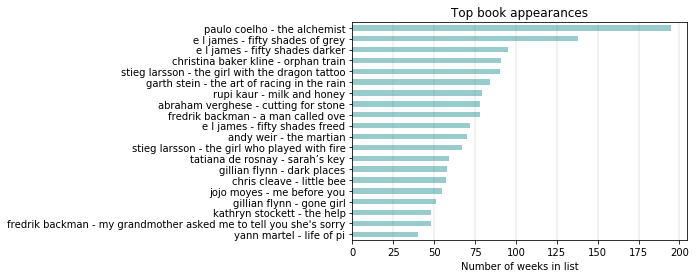

In [28]:
# visualize the books appearing most often 

import matplotlib.pyplot as plt

fig = num_bookappear.tail(20).plot.barh(color=(0.2, 0.6, 0.6, 0.5))

ax = plt.axes()
ax.grid(which='major', axis='x', color='gray', linestyle='-', linewidth=0.2)
plt.xlabel("Number of weeks in list")

plt.title("Top book appearances")

plt.show(fig)



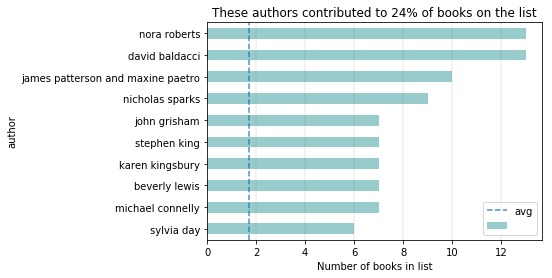

4
24


In [76]:
# visualize which authors has the most number of books on list

numbooksbyauthor= fiction_cleaned.groupby('author')['title'].apply(lambda x: len(x.unique()))
mostactiveauthors = numbooksbyauthor.sort_values(ascending = True).tail(10)

fig = mostactiveauthors.plot.barh(color=(0.2, 0.6, 0.6, 0.5))

ax = plt.axes()
ax.grid(which='major', axis='x', color='gray', linestyle='-', linewidth=0.2)
plt.xlabel("Number of books in list")

plt.title("These authors contributed to 24% of books on the list")

plt.axvline(numbooksbyauthor.mean(), linestyle='--', label = 'avg.', alpha = 0.8)
l = plt.legend()
ax.legend(labels= ['avg',''])

plt.show(fig)

## 86 books contributed by 10 most active authors 
mostactiveauthors.values.sum()

### top 10 authors make up 4% of the 210 authors appearing on list
print(10*100/len(fiction_cleaned['author'].unique()))

### top 10 authors contributed 24% of books on list
print (mostactiveauthors.values.sum()*100/len(fiction_cleaned['title'].unique()))

In [60]:
# more data exploration on most active authors
authors = mostactiveauthors.index
authorsubset = fiction_cleaned[fiction_cleaned['author'].isin(authors)]


num_titles = authorsubset.groupby('author')['title'].apply(lambda x: len(x.unique()))
#variable1.values
avg_rank = authorsubset.groupby('author')['rank'].apply(lambda x: x.mean()).round(1)

authorsubset2 = pd.concat((num_titles,avg_rank), axis=1)


authorsubset2['author']=authorsubset2.index
authorsubset2.columns = ['num_titles','avgrank','author']
authorsubset2 = authorsubset2.sort_values('num_titles')


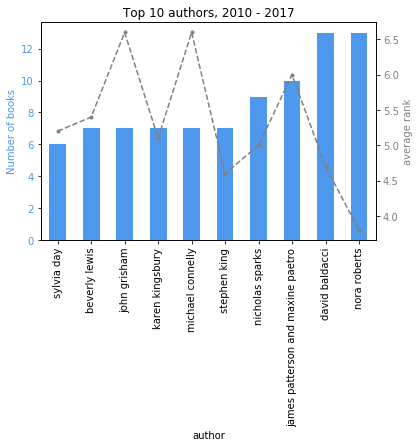

In [61]:
fig, ax = plt.subplots()

authorsubset2[['num_titles','author']].plot.bar(ax=ax , color = '#4e98ed', legend = False )
ax.set_ylabel('Number of books', color = '#4e98ed')

authorsubset2[['avgrank','author']].plot(ax=ax, secondary_y=True, style='.--', 
                                color='grey', legend = False)

ax.right_ax.set_ylabel('average rank', color = 'grey')


for tl in ax.get_yticklabels():
    tl.set_color('#4e98ed')

for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)

for tl in ax.right_ax.get_yticklabels():
    tl.set_color('grey')
    
plt.title("Top 10 authors, 2010 - 2017")


plt.show()

In [35]:
# explore relationship between number of books by an author, number of weeks author appeared on lists and average author rank


num_authappear = fiction_cleaned['author'].value_counts()
avg_rating = fiction_cleaned.groupby('author')['rank'].mean().round(1)
num_books_onlist = fiction_cleaned.groupby('author')['title'].apply(lambda x:len(x.unique()))

newdf = pd.concat((num_authappear,avg_rating,num_books_onlist), axis=1)
                  
newdf.columns = ['appearances','avgrank','numtitles']


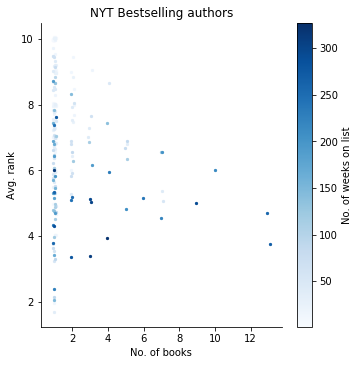

In [62]:
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors


g = sns.lmplot( x='numtitles', y='avgrank', data=newdf, fit_reg=False, hue ='appearances', 
                  legend = False, scatter_kws={"alpha":1,"s":5},
                  x_jitter=0.1,y_jitter=0.05 , palette='Blues')


normalize = mcolors.Normalize(vmin=newdf['appearances'].min(), 
                              vmax=newdf['appearances'].max())

colormap = cm.Blues

for n in newdf['appearances']:
    plt.plot(color=colormap(normalize(n)))

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(newdf['appearances'])
cbar = plt.colorbar(scalarmappaple)
cbar.ax.set_ylabel('No. of weeks on list')

plt.ylabel('Avg. rank')
plt.xlabel('No. of books')
plt.title("NYT Bestselling authors")

plt.show()

As expected, authors with fewer books tend to make fewer appearances on the list. (cluster towards top left of chart)

Authors with more books tend to have better avg. ranks. 


In [72]:
# explore common themes for books appearing on list based on word frequency analysis of book descriptions

fiction_cleaned = fiction_cleaned.dropna(subset=['description'])
fiction_desc = fiction_cleaned['description'].unique()
new = ' '.join(desc for desc in fiction_desc)

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import MWETokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

# mwetokenizer = MWETokenizer([('New', "York"), ('New','Hampshire'), ('Los','Angeles'),
#                            ('new','book'),('New','Orleans')])


word_tokens = word_tokenize(new.decode('utf','ignore'))
#word_tokens = mwetokenizer.tokenize(word_tokens)

lemmatizer = WordNetLemmatizer()

dct = {}
stopw = set(stopwords.words("english")+["novel", "book", "trilogy", "series", "new"])

for token in word_tokens: 
    token = token.lower()
    #token = lemmatizer.lemmatize(token)
    if token not in stopw:
        if token.isalpha():
            dct[token]=dct.get(token,0) + 1

sorted(dct.iteritems(), reverse=False)
len(dct)


2116

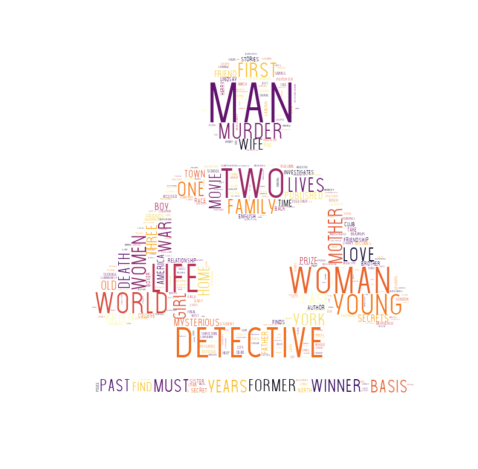

In [73]:
import random
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
#from palettable.colorbrewer.qualitative import Dark2_8
import matplotlib
import matplotlib.pyplot as plt


folder = "/Users/SherryT/Documents/Projects/Visualizations/"
font_path = "/Users/SherryT/Documents/Projects/Visualizations/TheLightFont.ttf"

imagefile = "read"

image_path = folder + "%s.png" % imagefile
icon = Image.open(image_path).convert("RGBA")

mask = Image.new("RGB", icon.size, (255,255,255))
mask.paste(icon,icon)
mask = np.array(mask)


wc = WordCloud(font_path = font_path, background_color="white", max_words=500, mask=mask,
               max_font_size=90, random_state=42, 
               colormap=matplotlib.cm.inferno)
wc.generate_from_frequencies(dct)

plt.figure(figsize=[12,8])

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()